In [1]:
import numpy as np
import tensorflow as tf
from tensorflow.keras import layers
from tensorflow.keras import losses
from tensorflow.keras import preprocessing
from tensorflow.keras.layers.experimental.preprocessing import TextVectorization
import os
os.environ['CUDA_VISIBLE_DEVICES'] = '-1'


In [2]:
import matplotlib.pyplot as plt


def plot_graphs(history, metric):
    plt.plot(history.history[metric])
    plt.plot(history.history['val_'+metric], '')
    plt.xlabel("Epochs")
    plt.ylabel(metric)
    plt.legend([metric, 'val_'+metric])

In [3]:
dataset_dir = '..\\data'
train_dir = f"{dataset_dir}\\train"
test_dir = f"{dataset_dir}\\test"
# train_dir = f"{dataset_dir}\\tr"
# test_dir = f"{dataset_dir}\\t"
batch_size = 32
seed = 42

In [4]:
train_dataset = preprocessing.text_dataset_from_directory(
    train_dir,
    batch_size=batch_size,
    validation_split=0.2,
    subset='training',
    seed=seed)

test_dataset = preprocessing.text_dataset_from_directory(
    test_dir, batch_size=batch_size)

Found 13567 files belonging to 3 classes.
Using 10854 files for training.
Found 13433 files belonging to 3 classes.


In [5]:
for text_batch, label_batch in train_dataset.take(1):
    for i in range(10):
        print("Sentence: ", text_batch.numpy()[i])
        print("Label:", label_batch.numpy()[i])
example = train_dataset.take(1)

Sentence:  b'S.V.S tuumaat ajatuksesta.??'
Label: 1
Sentence:  b'Multa ainaskii mukavia unijukan kuvia kaikille:)))'
Label: 2
Sentence:  b'Jauhoista ei puhuttu mit\xc3\xa4\xc3\xa4n, mutta se nyt oli taas sivuseikka.........'
Label: 1
Sentence:  b'suht tuore leffa..'
Label: 1
Sentence:  b'Kovin on suppea sanavarastosikin; "sommiporo", "Buahhahhaahaaa" jne.'
Label: 0
Sentence:  b'Toinen kaste, toinen henki'
Label: 1
Sentence:  b'Siihen asti, tutustukaa paikkoihin ja nauttikaa olostanne!'
Label: 2
Sentence:  b'Ja voiko n\xc3\xa4pp\xc3\xa4imist\xc3\xb6\xc3\xa4 k\xc3\xa4ytt\xc3\xa4\xc3\xa4 pelien pelaamiseen?'
Label: 1
Sentence:  b'Suosittelen Artiklan kursseja l\xc3\xa4mpim\xc3\xa4sti! :)'
Label: 2
Sentence:  b'Kiitos viel\xc3\xa4 ehdin muuttaa tiettyyn hotelliin..'
Label: 2


In [6]:
for text_batch, label_batch in train_dataset.take(1):
    print("Sentence: ", text_batch.numpy()[:3])
    print("Label:", label_batch.numpy()[:3])

Sentence:  [b'JA huom!'
 b'Ilmiantokulttuuri kaikessa vastenmielisyydess\xc3\xa4\xc3\xa4n on t\xc3\xb6rke\xc3\xa4t\xc3\xa4 riippumatta aiheesta.'
 b'Tavallisesti k\xc3\xa4ytetyiss\xc3\xa4 valaistuksissa, alle 300\xe2\x80\x93500 lx, l\xc3\xa4mpim\xc3\xa4t s\xc3\xa4vyt koetaan luonteviksi.']
Label: [1 0 1]


In [7]:
for i, label in enumerate(train_dataset.class_names):
    print("Label", i, "corresponds to", label)

Label 0 corresponds to neg
Label 1 corresponds to neut
Label 2 corresponds to pos


In [21]:
VOCAB_SIZE = 20000
encoder = TextVectorization(max_tokens=VOCAB_SIZE)
encoder.adapt(train_dataset.map(lambda text, label: text))
for text_batch, label_batch in train_dataset.take(1):
    for i in range(2):
        print("Sentence: ", text_batch.numpy()[i])
        print("Label:", label_batch.numpy()[i])

Sentence:  b'olen vain k\xc3\xa4ynyt sy\xc3\xb6m\xc3\xa4ss\xc3\xa4'
Label: 1
Sentence:  b'Takuuasioissa asiakas j\xc3\xa4\xc3\xa4 aina toiseksi, kun kyseess\xc3\xa4 ei ole kotimainen myyj\xc3\xa4.'
Label: 1


In [22]:
vocab = np.array(encoder.get_vocabulary())
print(vocab[:20])

['' '[UNK]' 'ja' 'on' 'ei' 'että' 'se' 'kun' 'niin' 'mutta' 'jos' 'ole'
 'en' 'tai' 'olen' 'voi' 'kuin' 'nyt' 'oli' 'sen']


In [23]:
for text_batch, label_batch in train_dataset.take(1):
    encoded_example = encoder(text_batch)[:3].numpy()
    print(encoded_example)
    for n in range(3):
        print("Original: ", text_batch[n].numpy())
        print("Round-trip: ", " ".join(vocab[encoded_example[n]]))
        print()

[[  405 11646     7 12018     3 17960  1291     1  3755    92   112    16
  18134     0     0     0     0     0     0     0     0     0     0     0
      0     0]
 [   54     1     1     0     0     0     0     0     0     0     0     0
      0     0     0     0     0     0     0     0     0     0     0     0
      0     0]
 [  911    96 17082  8468     1   235     0     0     0     0     0     0
      0     0     0     0     0     0     0     0     0     0     0     0
      0     0]]
Original:  b'Samoin univelka, kun ty\xc3\xb6ss\xc3\xa4k\xc3\xa4yvill\xc3\xa4 on puurrettava vapaa- aikakin saadakseen v\xc3\xa4h\xc3\xa4n enemm\xc3\xa4n kuin pummit.'
Round-trip:  samoin univelka kun työssäkäyvillä on puurrettava vapaa [UNK] saadakseen vähän enemmän kuin pummit             

Original:  b'Eik\xc3\xa4 opetuslapsiakaan kastettu !'
Round-trip:  eikä [UNK] [UNK]                       

Original:  b'Sin\xc3\xa4kin (mies) rienn\xc3\xa4t ajatuksiini luvattoman usein.'
Round-trip:  sinäkin mies ri

In [24]:
model = tf.keras.Sequential([
    encoder,
    tf.keras.layers.Embedding(len(encoder.get_vocabulary()), 64, mask_zero=True),
    tf.keras.layers.Bidirectional(tf.keras.layers.LSTM(64,  return_sequences=True)),
    tf.keras.layers.Bidirectional(tf.keras.layers.LSTM(32)),
    tf.keras.layers.Dense(64, activation='relu'),
    tf.keras.layers.Dropout(0.5),
    tf.keras.layers.Dense(3)
])
print([layer.supports_masking for layer in model.layers])

[False, True, True, True, True, True, True]


In [25]:
sample_text = """
Kyllä nelivetoinen on huonolla kelillä vakaampi ajaa kuin kaksivetoinen. 
on helvetin hyvä ajettava niin kuivalla kuin liukkallakin kelillä. Saattaahan neliveto olla parempi, mutta takavetosella on pärjätty, ja pärjätään, tosi hyvin. Itse en kaipaa nelivetoa, mutta jos joku tuntee olonsa turvallisemmaksi niin siitä vaan! 
mitähän mahdat tarkoittaa tolla vakaampi ajaa?? suurin merkitys on kyllä itse autolla vrt. paska/keskinkertainen neliveto vs hyvä etuveto. Ei esim audin nelivedot mitenkään ajettavuudella loista muiden yläpuolella. 
"""
predictions = model.predict(np.array([sample_text]))
print(predictions[0])

[-0.00078716  0.00855025  0.00722368]


In [26]:
padding = "the " * 2000
predictions = model.predict(np.array([sample_text, padding]))
print(predictions[0])

[-0.00078717  0.00855025  0.00722368]


In [27]:
model.compile(loss=tf.keras.losses.SparseCategoricalCrossentropy(from_logits=True),
              optimizer=tf.keras.optimizers.Adam(1e-4),
              metrics=['accuracy'])

In [ ]:
history = model.fit(train_dataset, epochs=15,
                    validation_data=test_dataset,
                    validation_steps=30)

Epoch 1/15
340/340 [==============================] - 53s 95ms/step - loss: 0.8866 - accuracy: 0.7251 - val_loss: 0.7856 - val_accuracy: 0.7417
Epoch 2/15
340/340 [==============================] - 30s 87ms/step - loss: 0.7779 - accuracy: 0.7315 - val_loss: 0.7635 - val_accuracy: 0.7323
Epoch 3/15
340/340 [==============================] - 28s 81ms/step - loss: 0.7023 - accuracy: 0.7434 - val_loss: 0.7312 - val_accuracy: 0.7646
Epoch 4/15
340/340 [==============================] - 27s 78ms/step - loss: 0.5450 - accuracy: 0.7910 - val_loss: 0.7817 - val_accuracy: 0.7458
Epoch 5/15
340/340 [==============================] - 27s 81ms/step - loss: 0.4200 - accuracy: 0.8418 - val_loss: 0.9852 - val_accuracy: 0.6990
Epoch 6/15
340/340 [==============================] - 29s 84ms/step - loss: 0.3290 - accuracy: 0.8843 - val_loss: 1.1759 - val_accuracy: 0.6938
Epoch 7/15
340/340 [==============================] - 32s 95ms/step - loss: 0.2611 - accuracy: 0.9180 - val_loss: 1.4939 - val_accuracy:

In [16]:
test_loss, test_acc = model.evaluate(test_dataset)

print('Test Loss:', test_loss)
print('Test Accuracy:', test_acc)

420/420 [==============================] - 10s 23ms/step - loss: 0.7157 - accuracy: 0.75621s -
Test Loss: 0.7157343029975891
Test Accuracy: 0.756197452545166


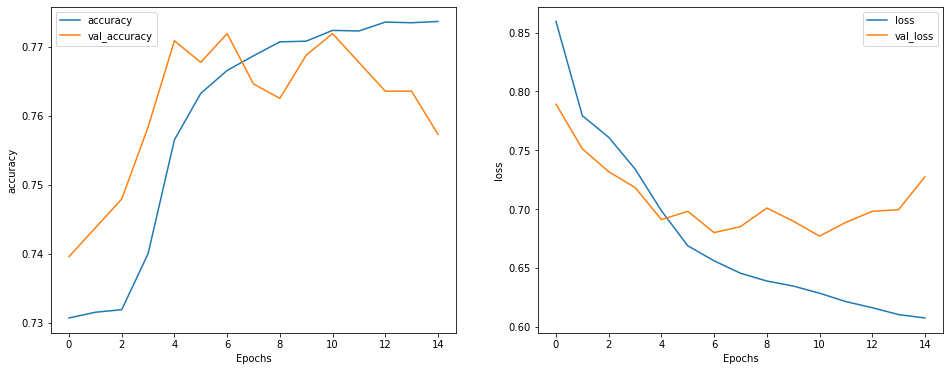

In [17]:
plt.figure(figsize=(16, 6))
plt.subplot(1, 2, 1)
plot_graphs(history, 'accuracy')
plt.subplot(1, 2, 2)
plot_graphs(history, 'loss')